In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import pickle
import json
import matplotlib.pyplot as plt
#import statsmodels.tsa.stattools as ts
from init_objects import *
from functions.stylizedfacts import *
from functions.helpers import organise_data
#from functions.evolutionaryalgo import quadratic_loss_function
from functions.inequality import gini, lorenz_curve
from distribution_model import *
import statsmodels.api as sm
from SALib.sample import latin
from matplotlib import style
from collections import OrderedDict
from functions.indirect_calibration import distr_model_performance
import seaborn as sns
import scipy.stats as stats
import scipy
from functions.find_bubbles import *
from statsmodels.iolib.summary2 import summary_col

In [2]:
style.use('ggplot')

# Effects of trend-following expectations on inequality

In [3]:
NRUNS = 10

In [4]:
with open('parameters.json', 'r') as f:
    params = json.loads(f.read())

In [5]:
params

{'ticks': 850,
 'fundamental_value': 166,
 'n_traders': 500,
 'std_fundamental': 0.0530163128919286,
 'spread_max': 0.004087,
 'init_stocks': 50,
 'trader_sample_size': 19,
 'horizon': 100,
 'trades_per_tick': 3,
 'std_noise': 0.15863974,
 'w_random': 0.056454,
 'strat_share_chartists': 0.20454462,
 'base_risk_aversion': 6.05054016,
 'fundamentalist_horizon_multiplier': 2.22042767,
 'mutation_intensity': 0.47684635,
 'average_learning_ability': 0.9962696}

In [6]:
burn_in_period = 0

### Run model

In [52]:
trdrs = []
orbs = []
for seed in range(NRUNS): 
    traders, orderbook = init_objects_distr(params, seed)
    traders, orderbook = pb_distr_model(traders, orderbook, params, seed)
    trdrs.append(traders)
    orbs.append(orderbook)

Start of simulation  0
Start of simulation  1
Start of simulation  2
Start of simulation  3
Start of simulation  4
Start of simulation  5
Start of simulation  6
Start of simulation  7
Start of simulation  8
Start of simulation  9
Start of simulation  10
Start of simulation  11
Start of simulation  12
Start of simulation  13
Start of simulation  14
Start of simulation  15
Start of simulation  16
Start of simulation  17
Start of simulation  18
Start of simulation  19


## Create the dataframe:

Columns: Gini, Palma, TwentyTwenty, share_chartist_expectations, Time_dummies 

In [71]:
#wealth_ot = []
ginis_ot = []
palmas_ot = []
twtws_ot = []
share_ch_ot = []
time = []
seed = []

for idx, traders in enumerate(trdrs):
    for t in range(params['ticks']):
        money = np.array([x.var.money[t] for x in traders])
        stocks = np.array([x.var.stocks[t] for x in traders])
        wealth = money + (stocks * orbs[idx].tick_close_price[t])

        share_top_10 = sum(np.sort(wealth)[int(len(wealth) * 0.9):]) / sum(wealth)
        share_bottom_40 = sum(np.sort(wealth)[:int(len(wealth) * 0.4)]) / sum(wealth)
        palmas_ot.append(share_top_10 / share_bottom_40)

        share_top_20 = np.mean(np.sort(wealth)[int(len(wealth) * 0.8):])
        share_bottom_20 = np.mean(np.sort(wealth)[:int(len(wealth) * 0.2)])
        twtws_ot.append(share_top_20 / share_bottom_20)

        ginis_ot.append(gini(wealth))
        
        sh_ch = sum([x.var.weight_chartist[t] / (x.var.weight_chartist[t] + x.var.weight_fundamentalist[t]) for x in traders]) / float(len(traders))
    
        share_ch_ot.append(sh_ch)
        
        seed.append(idx)
        
        time.append(t)

In [72]:
chart_df = pd.DataFrame({'gini': ginis_ot, 'palma': palmas_ot, 'twtw': twtws_ot, 'share_ch': share_ch_ot, 'time': time, 'seed': seed})
chart_df['const'] = 1

In [73]:
#chart_df = pd.get_dummies(chart_df, columns = ['time'], drop_first=True)
chart_df.head()

,gini,palma,twtw,share_ch,time,seed,const
0,0.232774,0.710790,3.802262,0.249951,0,0,1
1,0.232770,0.710788,3.802228,0.250423,1,0,1
2,0.232762,0.710746,3.801719,0.251104,2,0,1
3,0.232744,0.710647,3.800505,0.250430,3,0,1
4,0.232729,0.710569,3.799533,0.250991,4,0,1


### Scatter plot

Text(0.5, 1.0, 'twtw')

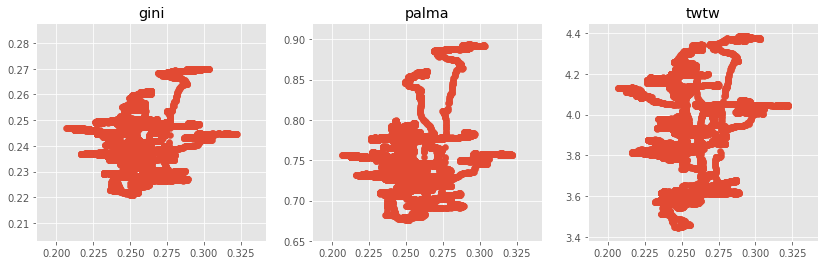

In [74]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=[14,4])

ax1.scatter(chart_df['share_ch'], chart_df['gini'])
ax2.scatter(chart_df['share_ch'], chart_df['palma'])
ax3.scatter(chart_df['share_ch'], chart_df['twtw'])

ax1.set_title('gini')
ax2.set_title('palma')
ax3.set_title('twtw')

## Regression model: 

$c_{i,t} = \alpha_i + \beta_{i} C_{i,t} + \beta_{t} \delta_t + \epsilon_{i,t}$

In [75]:
cols = [x for x in chart_df.columns if x not in['gini', 'palma', 'twtw']]

In [76]:
gini_res = sm.OLS(endog=chart_df['gini'], exog=chart_df[cols], missing='drop').fit()
palma_res = sm.OLS(endog=chart_df['palma'], exog=chart_df[cols], missing='drop').fit()
twtw_res = sm.OLS(endog=chart_df['twtw'], exog=chart_df[cols], missing='drop').fit()

In [77]:
info_dict={'R-squared' : lambda x: "{}".format(x.rsquared), 
           'No. observations' : lambda x: "{}".format(int(x.nobs))}

results_table = summary_col(results=[gini_res, palma_res, twtw_res],
                            float_format='%0.4f',
                            stars = True,
                            model_names=['Gini', 'Palma', '20-20'],
                            info_dict=info_dict,
                            regressor_order=['const', 'share_ch'])

results_table.add_title('Table - OLS Regressions')

print(results_table)

                          Table - OLS Regressions
                         Gini               Palma               20-20       
----------------------------------------------------------------------------
const            0.2314***           0.6629***           3.7551***          
                 (0.0009)            (0.0038)            (0.0204)           
share_ch         0.0291***           0.2813***           0.5447***          
                 (0.0035)            (0.0149)            (0.0802)           
seed             -0.0001***          0.0001***           -0.0032***         
                 (0.0000)            (0.0000)            (0.0003)           
time             0.0000***           0.0000***           0.0001***          
                 (0.0000)            (0.0000)            (0.0000)           
R-squared        0.05621781181395713 0.07892562087752397 0.04657495750445895
No. observations 21000               21000               21000              
Standard errors in parenth

In [60]:
from linearmodels import PanelOLS
from linearmodels import RandomEffects

## Random effects model

From: https://medium.com/pew-research-center-decoded/using-fixed-and-random-effects-models-for-panel-data-in-python-a795865736ab

Ego = Gini, Palma, Twenty-twenty

Endog = share_ch 


$c_{i,t} = \beta' mm_{i,t} + u_i + \epsilon_{i,t}$

where $mm_{i,t}$ is the relative share of chartists, $u_i$ is the random seed corresponding each simulation, and $\epsilon_{i,t}$ is the error term. .

In [78]:
re = chart_df.copy()

In [79]:
re = re.set_index(['seed', 'time'])

In [80]:
re.head(3)

gini     palma      twtw  share_ch  const
seed time                                               
0    0     0.232774  0.710790  3.802262  0.249951      1
     1     0.232770  0.710788  3.802228  0.250423      1
     2     0.232762  0.710746  3.801719  0.251104      1

In [81]:
exog = sm.add_constant(re['share_ch'])
gini_re_res = RandomEffects(re.gini, exog).fit()
palma_re_res = RandomEffects(re.palma, exog).fit()
twtw_re_res = RandomEffects(re.twtw, exog).fit()

### Random effect results:

In [82]:
gini_re_res#.variance_decomposition

Dep. Variable:,gini,R-squared:,0.0163
Estimator:,RandomEffects,R-squared (Between):,0.0013
No. Observations:,21000,R-squared (Within):,0.0163
Date:,"Tue, Mar 05 2019",R-squared (Overall):,0.0041
Time:,13:52:18,Log-likelihood,8.545e+04
Cov. Estimator:,Unadjusted,,
,,F-statistic:,347.91
Entities:,20,P-value,0.0000
Avg Obs:,1050.0,Distribution:,"F(1,20998)"
Min Obs:,1050.0,,
Max Obs:,1050.0,F-statistic (robust):,347.91


In [83]:
palma_re_res

Dep. Variable:,palma,R-squared:,0.0152
Estimator:,RandomEffects,R-squared (Between):,0.0257
No. Observations:,21000,R-squared (Within):,0.0152
Date:,"Tue, Mar 05 2019",R-squared (Overall):,0.0233
Time:,13:52:19,Log-likelihood,5.237e+04
Cov. Estimator:,Unadjusted,,
,,F-statistic:,325.11
Entities:,20,P-value,0.0000
Avg Obs:,1050.0,Distribution:,"F(1,20998)"
Min Obs:,1050.0,,
Max Obs:,1050.0,F-statistic (robust):,325.11


In [84]:
twtw_re_res

Dep. Variable:,twtw,R-squared:,0.0146
Estimator:,RandomEffects,R-squared (Between):,0.0009
No. Observations:,21000,R-squared (Within):,0.0146
Date:,"Tue, Mar 05 2019",R-squared (Overall):,0.0027
Time:,13:52:19,Log-likelihood,2.328e+04
Cov. Estimator:,Unadjusted,,
,,F-statistic:,311.60
Entities:,20,P-value,0.0000
Avg Obs:,1050.0,Distribution:,"F(1,20998)"
Min Obs:,1050.0,,
Max Obs:,1050.0,F-statistic (robust):,311.60


In [ ]:
# using this method, set time and group as index

# then exog is the variables 

In [19]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [20]:
chart_df.head(2)

,gini,palma,seed,share_ch,time,twtw,const
0,0.232774,0.710790,0,0.249974,0,3.802262,1
1,0.232774,0.710793,0,0.249061,1,3.802294,1


In [29]:
chart_df["Intercept"] = 1
exog = chart_df[["Intercept", "time", 'share_ch']]

In [30]:
gini_re = sm.MixedLM(chart_df["gini"], exog, groups=chart_df["seed"], exog_re=exog["Intercept"]).fit()

print(gini_re.summary())

          Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: gini      
No. Observations: 4200    Method:             REML      
No. Groups:       4       Scale:              0.0000    
Min. group size:  1050    Likelihood:         25197.6279
Max. group size:  1050    Converged:          Yes       
Mean group size:  1050.0                                
--------------------------------------------------------
              Coef. Std.Err.    z    P>|z| [0.025 0.975]
--------------------------------------------------------
Intercept     0.234    0.002 116.477 0.000  0.231  0.238
time          0.000    0.000  99.384 0.000  0.000  0.000
share_ch      0.016    0.001  11.793 0.000  0.013  0.018
Intercept Var 0.000    0.020                            



In [34]:
palma_re = sm.MixedLM(chart_df["palma"], exog, groups=chart_df["seed"], exog_re=exog["Intercept"]).fit()

print(palma_re.summary())

          Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: palma     
No. Observations: 4200    Method:             REML      
No. Groups:       4       Scale:              0.0000    
Min. group size:  1050    Likelihood:         18480.5520
Max. group size:  1050    Converged:          Yes       
Mean group size:  1050.0                                
--------------------------------------------------------
              Coef. Std.Err.    z    P>|z| [0.025 0.975]
--------------------------------------------------------
Intercept     0.721    0.010  74.581 0.000  0.702  0.740
time          0.000    0.000 114.635 0.000  0.000  0.000
share_ch      0.061    0.007   9.308 0.000  0.048  0.073
Intercept Var 0.000    0.096                            



In [36]:
twtw_re = sm.MixedLM(chart_df["twtw"], exog, groups=chart_df["seed"], exog_re=exog["Intercept"]).fit()

print(twtw_re.summary())

          Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: twtw      
No. Observations: 4200    Method:             REML      
No. Groups:       4       Scale:              0.0003    
Min. group size:  1050    Likelihood:         11206.4838
Max. group size:  1050    Converged:          Yes       
Mean group size:  1050.0                                
--------------------------------------------------------
               Coef. Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------
Intercept      3.643    0.064 56.633 0.000  3.517  3.769
time           0.000    0.000 62.584 0.000  0.000  0.000
share_ch       1.042    0.037 28.272 0.000  0.970  1.114
Intercept Var  0.016    0.750                           

